In [1]:
!pip install -q efficientnet
import pandas as pd
import numpy as np
from scipy import stats
import random
import os
import tensorflow as tf
import math
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import re
import tensorflow.keras.applications.efficientnet as eff
import tensorflow.keras.applications as tfka
import efficientnet.tfkeras as efn
from sklearn import metrics
import gc
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
import tensorflow_addons as tfa
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
from matplotlib import pyplot as plt
%matplotlib inline

2021-11-28 20:44:53.409235: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-28 20:44:53.409357: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-28 20:44:58.729947: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-28 20:44:58.732482: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-28 20:44:58.732521: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-28 20:44:58.732561: I tensorflow/stream_executor/cuda/cud

In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2021-11-28 20:44:59.877481: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-28 20:44:59.897464: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-28 20:44:59.897506: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2021-11-28 20:44:59.920070: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-28 20:44:59.920114: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2021-11-28 20:44:59.920617: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30020


REPLICAS:  8


In [3]:
# Configuration
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 20
BATCH_SIZE = 32
IMAGE_SIZE = [256, 256]
# Seed
SEED = 9527
seed = 9527
# Learning rate
LR = 0.0005
# Verbosity
VERBOSE = 2
# Label_dim
label_dim = 35

# dataset path

img_path = '../input/deepfoodie/dataset_1_images/dataset_1_images/Food Images/'
GCS_PATH = KaggleDatasets().get_gcs_path('deepfoodiedataloaders')

train_set = tf.io.gfile.glob(GCS_PATH + '/train' + '*.tfrec')
val_set = tf.io.gfile.glob(GCS_PATH + '/val' + '*.tfrec')

TARGET = "cleaned_ingredients"
VOCAB_SIZE = 13528

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# Data augmentation function
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image, label

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image


# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "cleaned_ingredients": tf.io.FixedLenSequenceFeature([], dtype=tf.int64, allow_missing=True),
        "orig_ingredients": tf.io.FixedLenFeature([], tf.string),
        "title": tf.io.FixedLenSequenceFeature([], dtype=tf.int64, allow_missing=True),
        "instructions": tf.io.FixedLenFeature([], tf.string),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
    title = example['title']
    label = example['cleaned_ingredients']
    return  image, label

def load_dataset(filenames, target, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames, target, ordered = False):
    dataset = load_dataset(filenames, target, ordered = ordered)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our validation tensors
def get_validation_dataset(filenames, target, ordered = True):
    dataset = load_dataset(filenames, target, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

# Function to count how many photos we have in
def count_data_items(filenames):
    # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(train_set)
print(f'Dataset: {NUM_TRAINING_IMAGES} training images')

Dataset: 10092 training images


In [5]:
train_dataset = get_training_dataset(train_set, TARGET, ordered = False)

In [6]:
for fo in train_dataset.take(1):
    print(fo[1], fo[0][1])
    print(fo[0][0].shape)

tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(32, 13528), dtype=int64) tf.Tensor(
[[[0.88509685 0.90666133 0.9313424 ]
  [0.8813976  0.90296215 0.92764324]
  [0.8776983  0.89926285 0.92394394]
  ...
  [0.86276853 0.87715864 0.9054476 ]
  [0.86276853 0.87715864 0.9054476 ]
  [0.8590693  0.87345934 0.90174836]]

 [[0.88509685 0.90666133 0.9313424 ]
  [0.8813976  0.90296215 0.92764324]
  [0.87399906 0.89556354 0.92024463]
  ...
  [0.86276853 0.87715864 0.9054476 ]
  [0.86276853 0.87715864 0.9054476 ]
  [0.8590693  0.87345934 0.90174836]]

 [[0.8813976  0.90296215 0.92764324]
  [0.8776983  0.89926285 0.92394394]
  [0.87399906 0.89556354 0.92024463]
  ...
  [0.86276853 0.87715864 0.9054476 ]
  [0.86276853 0.87715864 0.9054476 ]
  [0.86276853 0.87715864 0.9054476 ]]

 ...

 [[0.8891942  0.90018326 0.9461395 ]
  [0.86329937 0.8742884  0.92024463]
  [0.8519362  0.86640906 0.90174836]
  ...
  [0.5881107

In [7]:
val_dataset = get_validation_dataset(val_set, TARGET, ordered = True)

2021-11-28 20:45:09.110130: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 41, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638132309.106756939","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 41, Output num: 1","grpc_status":3}


In [8]:
STEPS_PER_EPOCH = count_data_items(train_set) // BATCH_SIZE
K.clear_session()


In [9]:
def get_lr_callback():
    # lr_start   = 0.0000001
    # lr_max     = 0.000005 * BATCH_SIZE
    lr_min     = 0.0000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < EPOCHS/2:
            lr = 0.000001 * (BATCH_SIZE - epoch)
        else:
            lr = lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

In [10]:
def get_model(mode):

    with strategy.scope():

        inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3), name = 'inp1')
    #     inp2 = tf.keras.layers.Input(shape = (MAX_LEN,))
    #     print(f'load Model_{mode}')
    #     y = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inp2)
    #     y = tf.keras.layers.Dropout(.5)(y)
    #     y = tf.keras.layers.LSTM(128)(y)
        if mode == 'eff0':
            x = efn.EfficientNetB0(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff1':
            x = efn.EfficientNetB1(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff2':
            x = efn.EfficientNetB2(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff3':
            x = efn.EfficientNetB3(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff4':
            x = efn.EfficientNetB4(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff5':
            x = efn.EfficientNetB5(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff6':
            x = efn.EfficientNetB6(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff7':
            x = efn.EfficientNetB7(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'ICPV2':
            x = tfka.InceptionResNetV2(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'ICPV3':
            x = tfka.InceptionV3(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'XCP':
            x = tfka.Xception(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'VGG16':
            x = tfka.VGG16(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'VGG19':
            x = tfka.VGG19(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'RN50':
            x = tfka.ResNet50(weights = 'imagenet', include_top = False)(inp)
        else:
            # 'RN101'
            x = tfka.ResNet101(weights = 'imagenet', include_top = False)(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        x = tf.keras.layers.Dense(256)(x)

        output = tf.keras.layers.Dense(VOCAB_SIZE, activation='sigmoid')(x)

        model = tf.keras.models.Model(inputs = [inp], outputs = [output])
        opt = tf.keras.optimizers.Adam(learning_rate = LR)

        model.compile(
            optimizer = opt,
            loss="binary_crossentropy"

            ) 

        return model

In [11]:
def plot_model(mode):
    model = get_model(mode=mode)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'Model_{mode}_{505}.h5', 
                                                        monitor = 'val_loss', 
                                                        verbose = 2, 
                                                        save_best_only = True,
                                                        save_weights_only = True, 
                                                        mode = 'min')
    history = model.fit(train_dataset,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = EPOCHS,
                            callbacks = [checkpoint, get_lr_callback()], 
                            validation_data = val_dataset,
                            verbose = VERBOSE)
    
    gc.collect()
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

27164672/27164032 [==============================] - 0s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 91s - loss: 0.1995 - val_loss: 0.0573


2021-11-28 20:46:59.810571: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 38741, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638132419.810156626","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 38741, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.05735, saving model to Model_eff1_505.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 19s - loss: 0.0068 - val_loss: 0.0329

Epoch 00002: val_loss improved from 0.05735 to 0.03289, saving model to Model_eff1_505.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 18s - loss: 0.0046 - val_loss: 0.0232

Epoch 00003: val_loss improved from 0.03289 to 0.02316, saving model to Model_eff1_505.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 18s - loss: 0.0042 - val_loss: 0.0201

Epoch 00004: val_loss improved from 0.02316 to 0.02014, saving model to Model_eff1_505.h5
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 18s - loss: 0.0040 - val_loss: 0.0170

Epoch 00005: val_loss improved from 0.02014 to 0.01697, saving model to Model_eff1_505.h5
Epoch 6/20

Ep

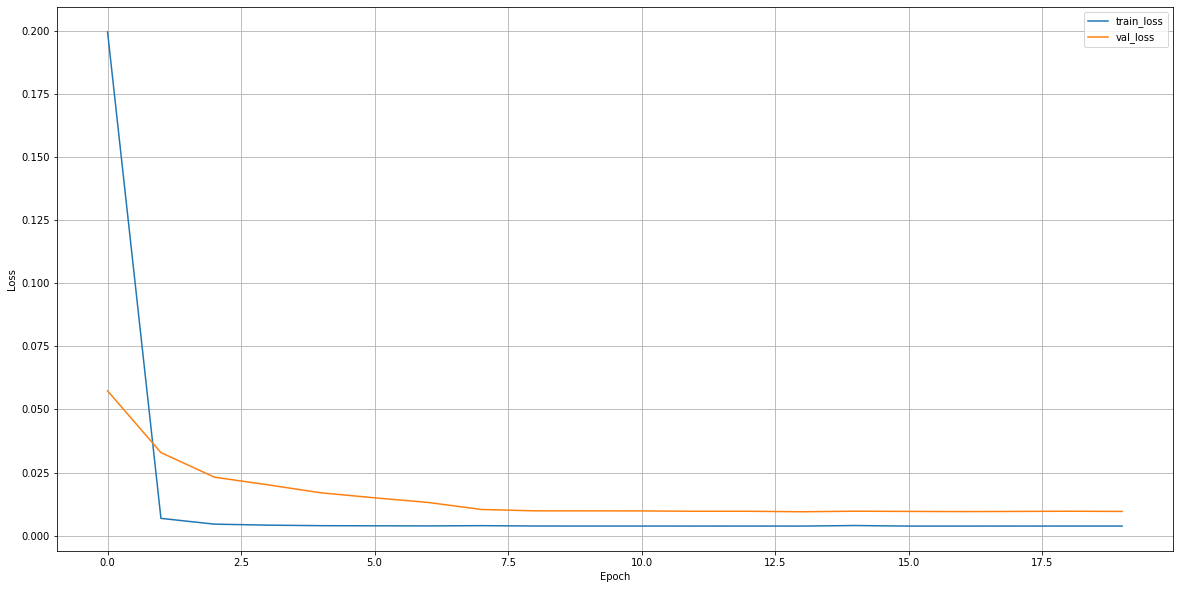

In [12]:
models = ['eff1','eff2','eff3','eff4','eff5','eff6','eff7','XCP', 'RN50']
plot_model(models[0])

31940608/31936256 [==============================] - 0s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 94s - loss: 0.2052 - val_loss: 0.0516


2021-11-28 20:55:01.257563: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 136653, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638132901.257424101","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 136653, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.05156, saving model to Model_eff2_505.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 19s - loss: 0.0067 - val_loss: 0.0301

Epoch 00002: val_loss improved from 0.05156 to 0.03008, saving model to Model_eff2_505.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 19s - loss: 0.0047 - val_loss: 0.0232

Epoch 00003: val_loss improved from 0.03008 to 0.02316, saving model to Model_eff2_505.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 19s - loss: 0.0041 - val_loss: 0.0186

Epoch 00004: val_loss improved from 0.02316 to 0.01863, saving model to Model_eff2_505.h5
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 19s - loss: 0.0040 - val_loss: 0.0155

Epoch 00005: val_loss improved from 0.01863 to 0.01550, saving model to Model_eff2_505.h5
Epoch 6/20

Ep

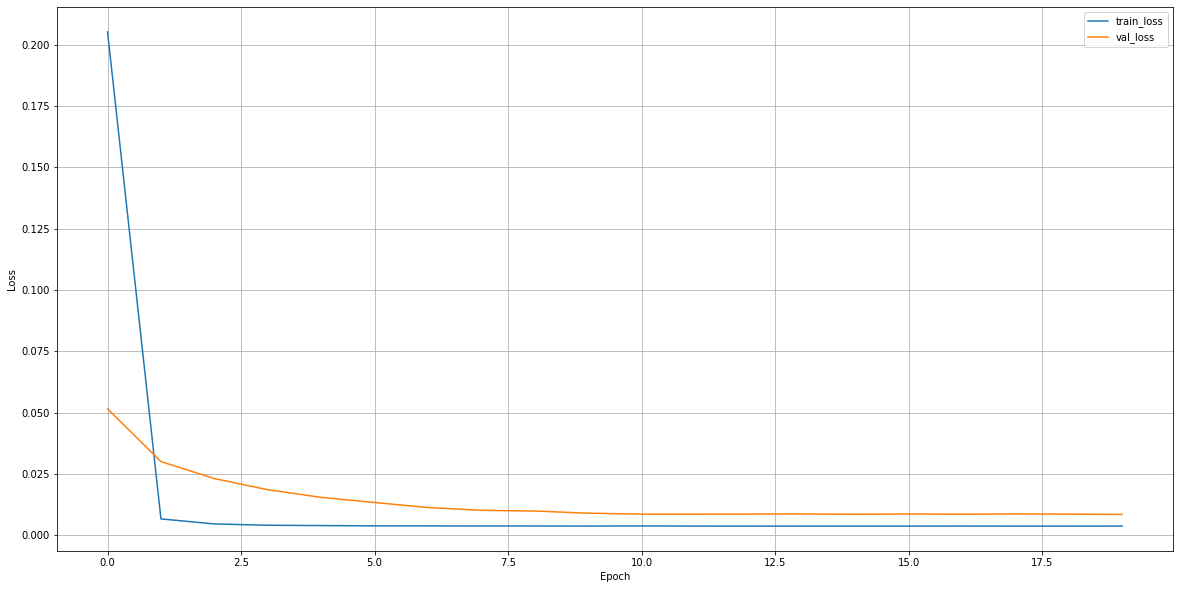

In [13]:
plot_model(models[1])

44113920/44107200 [==============================] - 0s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 103s - loss: 0.1947 - val_loss: 0.0579


2021-11-28 21:03:31.726307: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 242276, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638133411.725800494","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 242276, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.05788, saving model to Model_eff3_505.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 21s - loss: 0.0064 - val_loss: 0.0360

Epoch 00002: val_loss improved from 0.05788 to 0.03599, saving model to Model_eff3_505.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 21s - loss: 0.0045 - val_loss: 0.0227

Epoch 00003: val_loss improved from 0.03599 to 0.02269, saving model to Model_eff3_505.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 21s - loss: 0.0041 - val_loss: 0.0194

Epoch 00004: val_loss improved from 0.02269 to 0.01939, saving model to Model_eff3_505.h5
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 21s - loss: 0.0039 - val_loss: 0.0167

Epoch 00005: val_loss improved from 0.01939 to 0.01673, saving model to Model_eff3_505.h5
Epoch 6/20

Ep

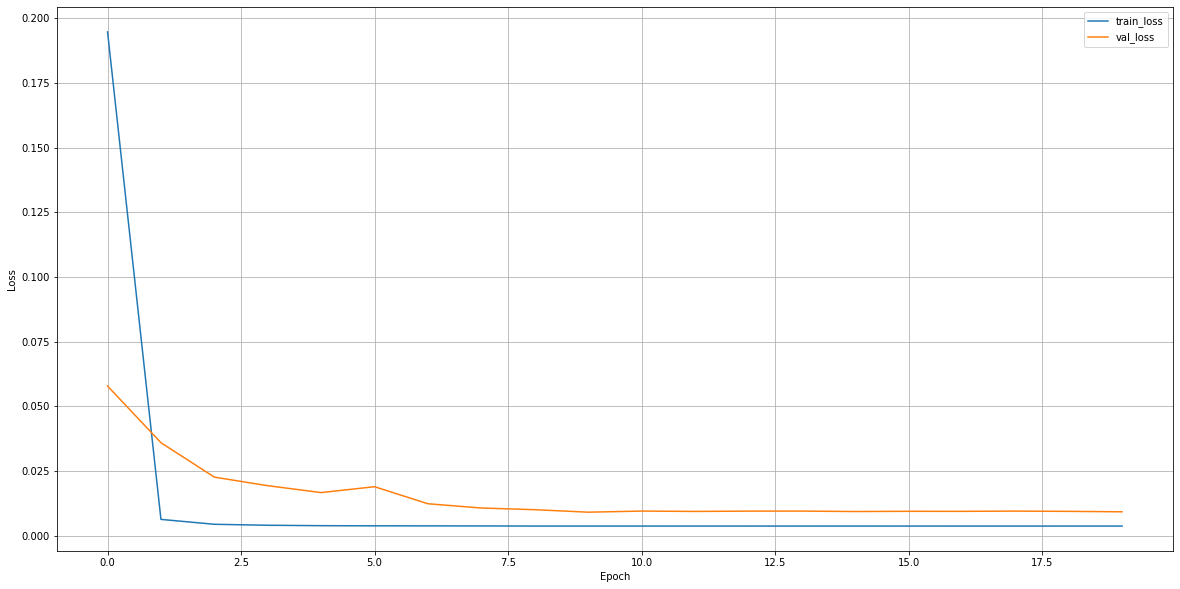

In [14]:
plot_model(models[2])

71892992/71892840 [==============================] - 1s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 130s - loss: 0.2228 - val_loss: 0.0899


2021-11-28 21:13:09.254321: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 350546, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638133989.253738504","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 350546, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.08989, saving model to Model_eff4_505.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 25s - loss: 0.0072 - val_loss: 0.0674

Epoch 00002: val_loss improved from 0.08989 to 0.06736, saving model to Model_eff4_505.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 25s - loss: 0.0046 - val_loss: 0.0481

Epoch 00003: val_loss improved from 0.06736 to 0.04814, saving model to Model_eff4_505.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 25s - loss: 0.0042 - val_loss: 0.0391

Epoch 00004: val_loss improved from 0.04814 to 0.03915, saving model to Model_eff4_505.h5
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 25s - loss: 0.0040 - val_loss: 0.0264

Epoch 00005: val_loss improved from 0.03915 to 0.02645, saving model to Model_eff4_505.h5
Epoch 6/20

Ep

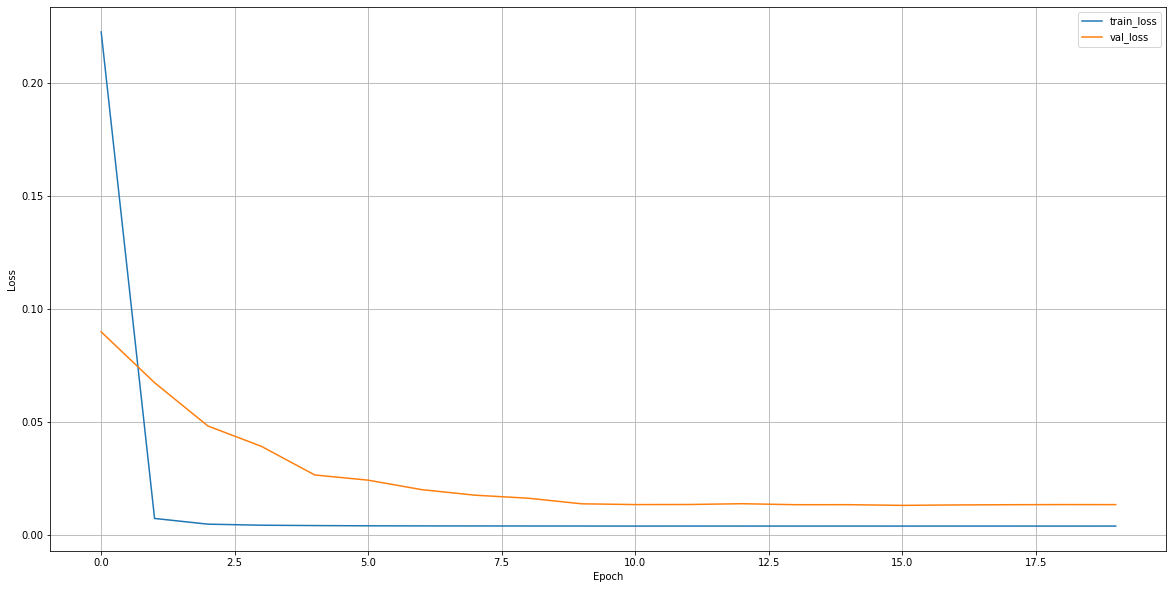

In [15]:
plot_model(models[3])

115515392/115515256 [==============================] - 1s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 166s - loss: 0.2185 - val_loss: 0.0475


2021-11-28 21:24:59.494744: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 494500, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638134699.494603064","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 494500, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.04749, saving model to Model_eff5_505.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 31s - loss: 0.0063 - val_loss: 0.0130

Epoch 00002: val_loss improved from 0.04749 to 0.01298, saving model to Model_eff5_505.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 31s - loss: 0.0045 - val_loss: 0.0072

Epoch 00003: val_loss improved from 0.01298 to 0.00722, saving model to Model_eff5_505.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 31s - loss: 0.0041 - val_loss: 0.0058

Epoch 00004: val_loss improved from 0.00722 to 0.00584, saving model to Model_eff5_505.h5
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 31s - loss: 0.0039 - val_loss: 0.0052

Epoch 00005: val_loss improved from 0.00584 to 0.00518, saving model to Model_eff5_505.h5
Epoch 6/20

Ep

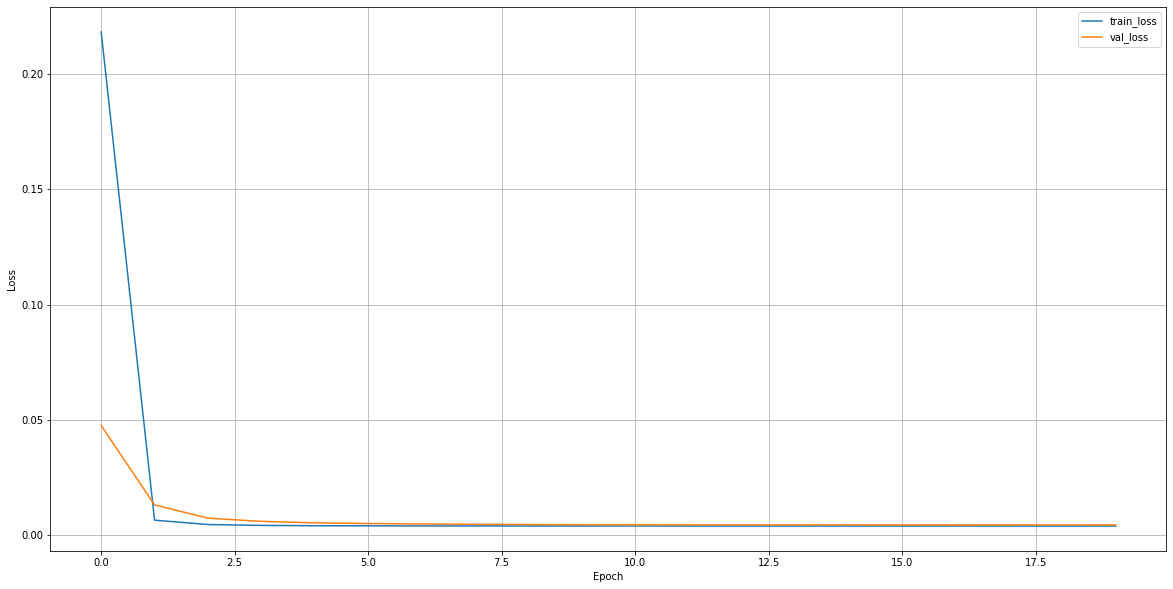

In [16]:
plot_model(models[4])

165527552/165527152 [==============================] - 3s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 193s - loss: 0.2611 - val_loss: 0.3113


2021-11-28 21:39:25.035097: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 675840, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638135565.034993448","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 675840, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.31129, saving model to Model_eff6_505.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 36s - loss: 0.0107 - val_loss: 0.2529

Epoch 00002: val_loss improved from 0.31129 to 0.25293, saving model to Model_eff6_505.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 36s - loss: 0.0056 - val_loss: 0.1737

Epoch 00003: val_loss improved from 0.25293 to 0.17372, saving model to Model_eff6_505.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 36s - loss: 0.0049 - val_loss: 0.1133

Epoch 00004: val_loss improved from 0.17372 to 0.11333, saving model to Model_eff6_505.h5
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 36s - loss: 0.0044 - val_loss: 0.0865

Epoch 00005: val_loss improved from 0.11333 to 0.08653, saving model to Model_eff6_505.h5
Epoch 6/20

Ep

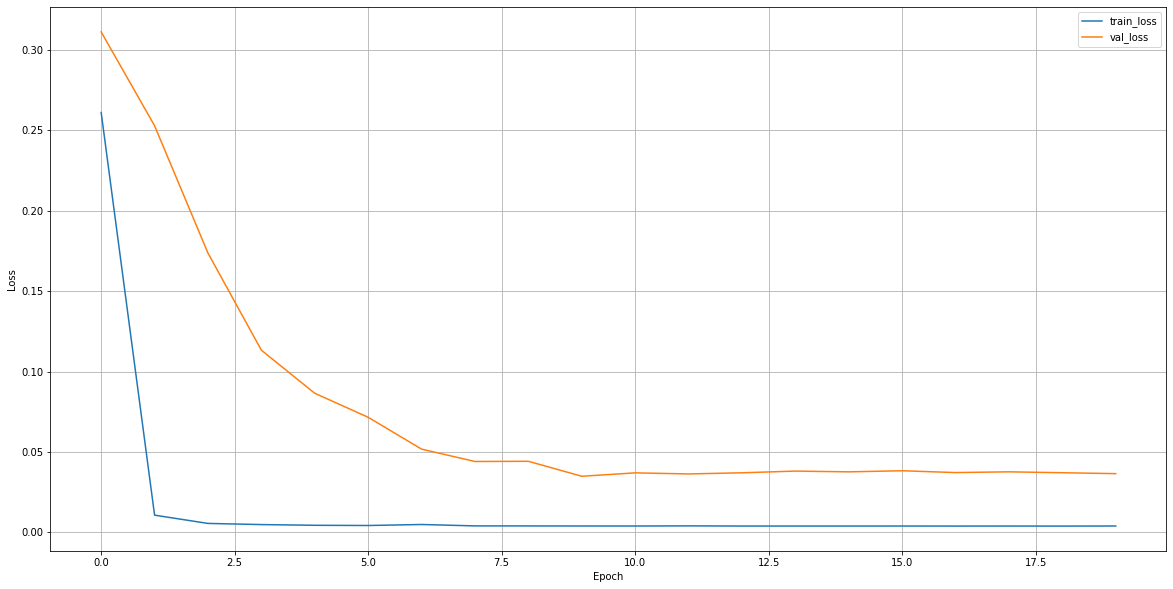

In [17]:
plot_model(models[5])

258441216/258434480 [==============================] - 3s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 240s - loss: 0.2664 - val_loss: 0.1833


2021-11-28 21:55:59.822902: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 848054, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638136559.822528674","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 848054, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.18326, saving model to Model_eff7_505.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 46s - loss: 0.0087 - val_loss: 0.0819

Epoch 00002: val_loss improved from 0.18326 to 0.08191, saving model to Model_eff7_505.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 46s - loss: 0.0050 - val_loss: 0.0533

Epoch 00003: val_loss improved from 0.08191 to 0.05325, saving model to Model_eff7_505.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 46s - loss: 0.0043 - val_loss: 0.0275

Epoch 00004: val_loss improved from 0.05325 to 0.02752, saving model to Model_eff7_505.h5
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 46s - loss: 0.0042 - val_loss: 0.0164

Epoch 00005: val_loss improved from 0.02752 to 0.01637, saving model to Model_eff7_505.h5
Epoch 6/20

Ep

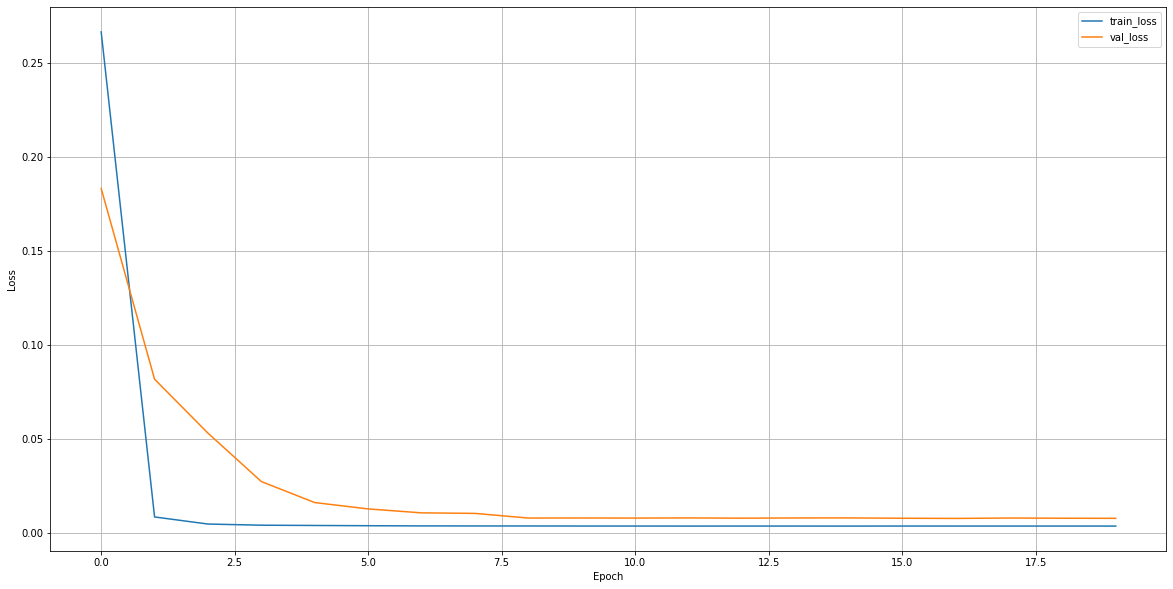

In [18]:
plot_model(models[6])

83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 66s - loss: 0.1831 - val_loss: 0.0121


2021-11-28 22:12:52.686155: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 973690, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638137572.685796637","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 973690, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.01214, saving model to Model_XCP_505.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 15s - loss: 0.0061 - val_loss: 0.0061

Epoch 00002: val_loss improved from 0.01214 to 0.00614, saving model to Model_XCP_505.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 15s - loss: 0.0044 - val_loss: 0.0052

Epoch 00003: val_loss improved from 0.00614 to 0.00521, saving model to Model_XCP_505.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 15s - loss: 0.0040 - val_loss: 0.0049

Epoch 00004: val_loss improved from 0.00521 to 0.00487, saving model to Model_XCP_505.h5
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 15s - loss: 0.0039 - val_loss: 0.0047

Epoch 00005: val_loss improved from 0.00487 to 0.00467, saving model to Model_XCP_505.h5
Epoch 6/20

Epoch 0

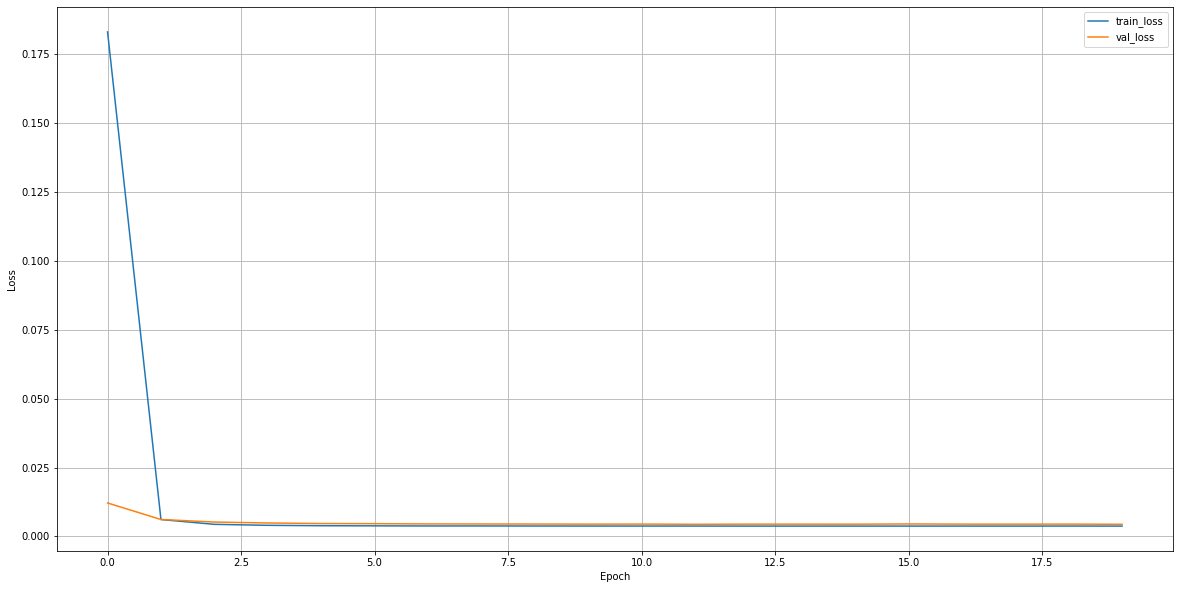

In [19]:
plot_model(models[7])

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 75s - loss: 0.1034 - val_loss: 0.0165


2021-11-28 22:19:28.652409: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1060317, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638137968.652331111","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1060317, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.01652, saving model to Model_RN50_505.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 15s - loss: 0.0040 - val_loss: 0.0040

Epoch 00002: val_loss improved from 0.01652 to 0.00405, saving model to Model_RN50_505.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 15s - loss: 0.0038 - val_loss: 0.0039

Epoch 00003: val_loss improved from 0.00405 to 0.00386, saving model to Model_RN50_505.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 15s - loss: 0.0038 - val_loss: 0.0039

Epoch 00004: val_loss improved from 0.00386 to 0.00385, saving model to Model_RN50_505.h5
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 15s - loss: 0.0038 - val_loss: 0.0038

Epoch 00005: val_loss improved from 0.00385 to 0.00385, saving model to Model_RN50_505.h5
Epoch 6/20

Ep

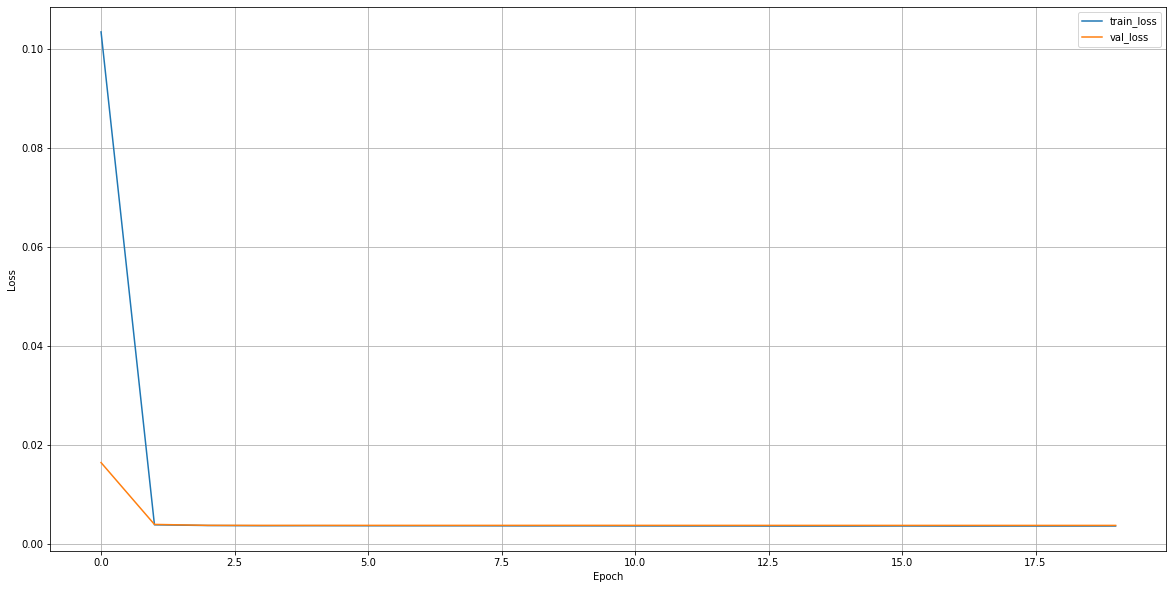

In [20]:
plot_model(models[8])